## Part 1 - Dealing with Missing Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from rfpimp import * 

We will use slightly modified versions of the `evaluate` and `showimp` functions from the last few notebooks. 

In [2]:
def evaluate(X, y, n_estimators=50):
    rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 is {oob:.5f} using {n:,d} tree nodes with {h} median tree depth")
    return rf, oob

In [3]:
def showimp(rf, X, y):
    features = list(X.columns)
    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

### Read in the Data

To prep the data for loading, please refer to [Section 7.1](https://mlbook.explained.ai/bulldozer-intro.html#sec:7.1) of *The Mechanics of Machine learning*. Once we have the data in the proper format, we are going to read it in and make a copy. Making a copy is a good idea as then we will always have the original data available without having to reload it. 

In [4]:
df_raw = pd.read_feather("bulldozer-train.feather")
df = df_raw.copy()

Now let's see how much data we are dealing wih:

In [5]:
df.shape

(389125, 53)

And get an idea of what it looks like:

In [7]:
df.head().T

,0,1,2,3,4
SalesID,1646770,1404019,1415646,1596358,1821514
SalePrice,9500,24000,35000,19000,14000
MachineID,1126363,1169900,1262088,1433229,1194089
ModelID,8434,7110,3357,8247,10150
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1986,1975,1978,1980
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,None,None,None,None,None
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


Let's get a bit more information on the data so we can start planning what we need to do. To do this, we will use the following function:

In [8]:
def sniff_modified(df):
    
    info = pd.DataFrame()
    info['data type'] = df.dtypes
    info['percent missing'] = df.isnull().sum()/len(df) *100
    info['No. unique'] = df.apply(lambda x: x.nunique())
    info['unique values'] = df.apply(lambda x: x.unique())
    return info.sort_values('data type')

In [9]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
SalesID,int64,0.000000,389125,"[1646770, 1404019, 1415646, 1596358, 1821514, ..."
SalePrice,int64,0.000000,878,"[9500, 24000, 35000, 19000, 14000, 22500, 3100..."
MachineID,int64,0.000000,332365,"[1126363, 1169900, 1262088, 1433229, 1194089, ..."
ModelID,int64,0.000000,5154,"[8434, 7110, 3357, 8247, 10150, 7267, 7620, 41..."
datasource,int64,0.000000,5,"[132, 136, 121, 172, 149]"
YearMade,int64,0.000000,71,"[1974, 1986, 1975, 1978, 1980, 1976, 1987, 197..."
auctioneerID,float64,5.174687,30,"[18.0, 99.0, 4.0, 1.0, 6.0, 24.0, 19.0, 10.0, ..."
MachineHoursCurrentMeter,float64,64.717764,14526,"[nan, 1640.0, 1400.0, 2249.0, 729.0, 1237.0, 4..."
saledate,datetime64[ns],0.000000,3816,"[1989-01-17 00:00:00, 1989-01-31 00:00:00, 198..."
Coupler,object,46.826855,3,"[None, None or Unspecified, Manual, Hydraulic]"


### Quickly get a Baseline Model

As we did before, we need to specify our target (`SalePrice`) and then focus in on the numeric data and create and evaluate a baseline model. That means we will consider only these features for now: `SalesID`, `MachineID`, `ModelID`, `datasource`, `YearMade`, `auctioneerID`, and `MachineHoursCurrentMeter`. 

However, as seen above, the last two contain missing values, so we will have to deal with that in order to create a model. 

Remember that we need two things to train a model:
- all numeric data
- no missing values

In [10]:
basefeatures = ['SalesID', 'MachineID','ModelID','datasource','YearMade','auctioneerID','MachineHoursCurrentMeter']

In [11]:
X = df[basefeatures]
y = df['SalePrice']

X = X.fillna(0)

In [12]:
%%time
rf , oob = evaluate(X, y, n_estimators=100)

OOB R^2 is 0.78686 using 44,996,040 tree nodes with 55.0 median tree depth
CPU times: total: 13min 15s
Wall time: 2min 7s


In [13]:
%%time
rf , oob = evaluate(X, y, n_estimators=50)

OOB R^2 is 0.78123 using 22,496,166 tree nodes with 56.0 median tree depth
CPU times: total: 6min 28s
Wall time: 1min 3s


In [14]:
df = df.iloc[-100000:]

In [15]:
X = df[basefeatures]
y = df['SalePrice']

X = X.fillna(0)

In [16]:
%%time
rf , oob = evaluate(X, y, n_estimators=100)

OOB R^2 is 0.85015 using 11,111,358 tree nodes with 46.0 median tree depth
CPU times: total: 3min 1s
Wall time: 29 s


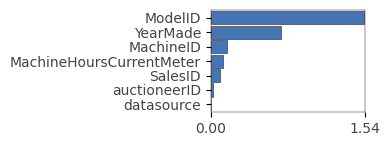

In [17]:
showimp(rf,X,y)

### Cleaning up the Data

In order to try to improve our model performance (which may or may not be possible) we will clean up our data with the following procedure:
- Drop features that have no predictive value or have known problems that can't be fixed;
- Convert actual categorical features from current numeric data type to an object data type;
- normalize the representation of missing data;
- clean up strings that are actually numeric; 
- extract features;
- encode categorical features; 
- deal with missing data. 

In [18]:
df.drop(['SalesID', 'MachineID'], axis=1, inplace=True)
df.columns

C:\Users\MAFSHAR\AppData\Local\Temp\ipykernel_9944\2159813579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['SalesID', 'MachineID'], axis=1, inplace=True)


Index(['SalePrice', 'ModelID', 'datasource', 'auctioneerID', 'YearMade',
       'MachineHoursCurrentMeter', 'UsageBand', 'saledate', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [19]:
df['auctioneerID'] = df['auctioneerID'].astype(str)

C:\Users\MAFSHAR\AppData\Local\Temp\ipykernel_9944\2422324984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['auctioneerID'] = df['auctioneerID'].astype(str)


In [20]:
missing = pd.DataFrame({'color' : ['Unsecified' , 'blue', None, '', 'None', 'red'],  
                        'width' : [12 , -5 , '', 20 , 800000, np.nan] })

In [21]:
missing.isnull()

,color,width
0,False,False
1,False,False
2,True,False
3,False,False
4,False,False
5,False,True


In [22]:
df['Drive_System'].unique()

array([None, 'Two Wheel Drive', 'Four Wheel Drive', 'No',
       'All Wheel Drive'], dtype=object)

In [24]:
df['Backhoe_Mounting'].unique()

array(['None or Unspecified', None, 'Yes'], dtype=object)

In [26]:
df['fiModelSeries'].unique()

array([None, 'LC', 'III', 'II', '-12', '-5', 'V', '-7', '-21', '-2', '-8',
       '6.00E+00', '6', '-2N', 'IV', '-1', '-3LK', '-3PT', '-6',
       '7.00E+00', '-3MC', '7', '-15', '15', '-3', '-3LC', '5', '-5L',
       '-20', '-1L', '-6E', 'XT', '8', '3', '-18', '-3L', 'VHP', '5N',
       'ZTS', 'A', '22', '-5H', '2', '-6K', '1', '-2C', '2B', '-3EO',
       'SeriesII', '-7E', 'LT', '-16', '17', 'IV-2', '-4', '2T', '-6LC',
       'XLT', '18', '#NAME?', 'D', 'E', '6F', '-21A', ' III', '-7K',
       'FASTRRACK', 'GALEO', '-5LC', '-1.50E+01', 'TC', '20', 'L', '-6A',
       '16', 'V-2', '21KomStat', '6LE', '-5E', '-3H', '7A', '12', '-6C',
       '-17', '3C', '-7B', 'ZHS', '3A', 'WX', 'LGP', '-6LK', 'AWS', '6LK',
       '14FT', '6L', '-3C', 'Elite', 'Q', '-1B', 'EX', 'VI', '4', 'H',
       'LV', '21KomStatII', '7L', '-11'], dtype=object)

In [35]:
from pandas.api.types import is_object_dtype,is_string_dtype
def df_normalize_string(df):
    for col in df.columns:
        if is_object_dtype(df[col]) or is_string_dtype(df[col]):
            df[col] = df[col].str.lower()
            df[col] = df[col].fillna(np.nan)
            df[col] = df[col].replace('none or unspecified', np.nan)
            df[col] = df[col].replace('none', np.nan)
            df[col] = df[col].replace('#name?', np.nan)
            df[col] = df[col].replace('', np.nan)       

In [36]:
df_normalize_string(df)

In [37]:
df['Backhoe_Mounting'].unique()

array([nan, 'yes'], dtype=object)

In [38]:
df['Tire_Size'].unique()

array([nan, '26.5', '20.5', '17.5', '23.5', '14"', '13"', '29.5', '17.5"',
       '15.5"', '20.5"', '15.5', '23.5"', '7.0"', '10"', '23.1"'],
      dtype=object)

In [39]:
df['Undercarriage_Pad_Width'].unique()

array([nan, '36 inch', '24 inch', '20 inch', '34 inch', '26 inch',
       '30 inch', '28 inch', '32 inch', '16 inch', '31 inch', '18 inch',
       '22 inch', '33 inch', '14 inch', '27 inch', '25 inch', '15 inch'],
      dtype=object)

In [43]:
def extract_size(df, colname):
    df[colname] = df[colname].str.extract('(\d+\.\d+|\d+)' , expand=True)
    df[colname] = df[colname].replace('',np.nan)
    df[colname] = pd.to_numeric(df[colname])

In [44]:
extract_size(df, 'Tire_Size')

In [45]:
extract_size(df, 'Undercarriage_Pad_Width')

In [46]:
df['Tire_Size'].unique()

array([ nan, 26.5, 20.5, 17.5, 23.5, 14. , 13. , 29.5, 15.5,  7. , 10. ,
       23.1])

In [47]:
df['Undercarriage_Pad_Width'].unique()

array([nan, 36., 24., 20., 34., 26., 30., 28., 32., 16., 31., 18., 22.,
       33., 14., 27., 25., 15.])

In [49]:
df['Stick_Length'].unique()

array([nan, '10\' 6"', '9\' 6"', '9\' 7"', '10\' 2"', '12\' 8"',
       '12\' 10"', '9\' 10"', '9\' 8"', '11\' 0"', '10\' 10"', '8\' 6"',
       '9\' 5"', '14\' 1"', '11\' 10"', '6\' 3"', '12\' 4"', '8\' 2"',
       '8\' 10"', '8\' 4"', '15\' 9"', '13\' 10"', '13\' 7"', '15\' 4"',
       '19\' 8"'], dtype=object)

In [52]:
length = '10\' 6"'
feet, inches= length.split("' ")
feet, inches

('10', '6"')

In [57]:
def parse_length(length):
    if pd.isnull(length):
        return np.nan
    else:
        feet, inches = length.split("' ")
        feet = float(feet)
        inches = float(inches.replace("\"",""))
        return (12*feet) + inches

In [58]:
df['Stick_Length'] = df['Stick_Length'].apply(lambda x:parse_length(x))

In [59]:
df['Stick_Length'].unique()

array([ nan, 126., 114., 115., 122., 152., 154., 118., 116., 132., 130.,
       102., 113., 169., 142.,  75., 148.,  98., 106., 100., 189., 166.,
       163., 184., 236.])

In [60]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
SalePrice,int64,0.000,574,"[8300, 15500, 26000, 80000, 77500, 17750, 4900..."
ModelID,int64,0.000,3703,"[4663, 11859, 1133, 457, 3858, 4584, 2249, 340..."
datasource,int64,0.000,5,"[136, 132, 121, 172, 149]"
YearMade,int64,0.000,63,"[1985, 1995, 1997, 1993, 2000, 1999, 2005, 199..."
Tire_Size,float64,85.891,11,"[nan, 26.5, 20.5, 17.5, 23.5, 14.0, 13.0, 29.5..."
Stick_Length,float64,93.602,24,"[nan, 126.0, 114.0, 115.0, 122.0, 152.0, 154.0..."
saledate,datetime64[ns],0.000,674,"[2009-01-23 00:00:00, 2009-01-24 00:00:00, 200..."
Undercarriage_Pad_Width,float64,96.806,17,"[nan, 36.0, 24.0, 20.0, 34.0, 26.0, 30.0, 28.0..."
MachineHoursCurrentMeter,float64,20.955,13174,"[0.0, nan, 2301.0, 2132.0, 212.0, 301.0, 3187...."
Backhoe_Mounting,object,99.998,1,"[nan, yes]"
